<a href="https://colab.research.google.com/github/ajaym416/transfer_learning/blob/main/transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torchvision.transforms as T
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader
import time
import copy


In [2]:
#Different Transformations for the data augmentation 
def get_train_transform():
  return (T.Compose([
                     T.Resize(224),
                     T.RandomHorizontalFlip(p=0.5),
                     T.RandomRotation(15),
                    #  T.RandomCrop(204,),
                     T.ToTensor(),
                     T.ColorJitter(brightness=(0.5,1.5), contrast=(0.5,1.5), saturation=(0.5,1.5), hue=(-0.1,0.1)),
                    #  T.Normalize(mean=[0.4732, 0.3933, 0.3759], std=[0.2000, 0.1905, 0.1839])
                     T.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])

                    ]))
def get_val_transform():
  return (T.Compose([T.ToTensor(),
                     ]))

In [3]:
os.makedirs("/content/STL10",exist_ok =True)
root= "/content/STL10"
 
batch_size = 32
# num_workers = 12

    
train_data = datasets.STL10(root=root, split='train', transform=get_train_transform(), download=True)
test_data = datasets.STL10(root=root, split='test', transform=get_val_transform(), download=True)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True,drop_last=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True,drop_last=False)


Files already downloaded and verified
Files already downloaded and verified


In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [5]:
device

device(type='cuda', index=0)

images-size: torch.Size([32, 3, 224, 224])
out-size: torch.Size([3, 906, 1810])


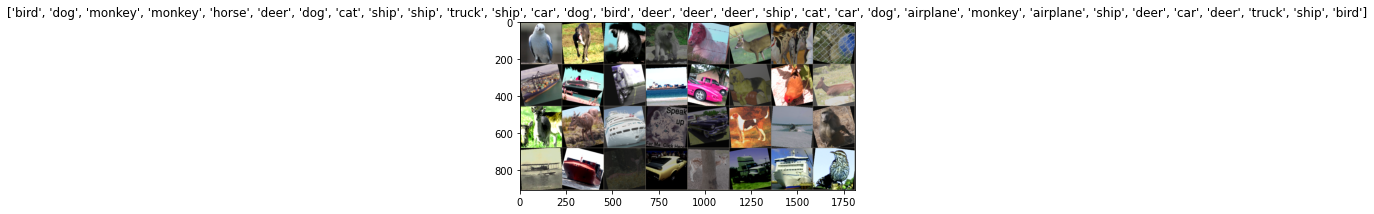

In [6]:
def imshow(inp, title=None):
    inp = inp.cpu() if device else inp
    inp = inp.numpy().transpose((1, 2, 0))
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(20,20))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    
images, labels = next(iter(train_loader)) 
print("images-size:", images.shape)

out = torchvision.utils.make_grid(images)
print("out-size:", out.shape)

imshow(out, title=[train_data.classes[x] for x in labels])

In [7]:
#Using pretrained Resnet34 model
net = models.resnet34(pretrained=True)
net = net.cuda() if torch.cuda.is_available() else net
net


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [8]:
#Adding the final dense layer to the network 
from collections import OrderedDict
def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

num_ftrs = net.fc.in_features
net.fc =nn.Sequential(OrderedDict([
    ("fc_dropout",nn.Dropout(0.5)),
    ("fc_linear",nn.Linear(num_ftrs, 10))])
)
net.fc = net.fc.cuda() if torch.cuda.is_available() else net.fc

In [9]:
#Freeze or unfreeze the early layers of the model
FREEZE_EARLY_LAYERS=True
criterion = nn.CrossEntropyLoss()
if FREEZE_EARLY_LAYERS:
  for para in net.parameters():
    para.requires_grad = False
  net.fc.fc_linear.weight.requires_grad=True
  net.fc.fc_linear.bias.requires_grad=True
  for name, param in net.named_parameters():
       if param.requires_grad:
         print(name)
  optimizer = optim.Adam(net.fc.parameters(), lr=0.0001)
else:
  optimizer = optim.Adam(net.parameters(), lr=0.0001)



fc.fc_linear.weight
fc.fc_linear.bias


In [11]:
#Train the model
n_epochs = 20
print_every = 10
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_loader)
for epoch in range(1, n_epochs+1):
    start = time.time()
    running_loss = 0.0
    correct = 0
    total=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, target_) in enumerate(train_loader):
        data_, target_ = data_.to(device), target_.to(device)
        optimizer.zero_grad()
        
        outputs = net(data_)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        net.eval()
        for data_t, target_t in (test_loader):
            data_t, target_t = data_t.to(device), target_t.to(device)
            outputs_t = net(data_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t/total_t)
        val_loss.append(batch_loss/len(test_loader))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')

        
        if network_learned:
            valid_loss_min = batch_loss
            torch.save(net.state_dict(), 'resnet.pt')
            print('Improvement-Detected, save-model')
    net.train()
    end = time.time()
    print(end - start)

Epoch 1

Epoch [1/20], Step [0/157], Loss: 2.7053
Epoch [1/20], Step [20/157], Loss: 2.6051
Epoch [1/20], Step [40/157], Loss: 2.4735
Epoch [1/20], Step [60/157], Loss: 2.4301
Epoch [1/20], Step [80/157], Loss: 2.4372
Epoch [1/20], Step [100/157], Loss: 2.3574
Epoch [1/20], Step [120/157], Loss: 2.1870
Epoch [1/20], Step [140/157], Loss: 2.1587

train-loss: 2.3774, train-acc: 15.8600
validation loss: 2.3145, validation acc: 18.9250

Improvement-Detected, save-model
109.18455338478088
Epoch 2

Epoch [2/20], Step [0/157], Loss: 1.7887
Epoch [2/20], Step [20/157], Loss: 2.2581
Epoch [2/20], Step [40/157], Loss: 2.0254
Epoch [2/20], Step [60/157], Loss: 1.9285
Epoch [2/20], Step [80/157], Loss: 1.6919
Epoch [2/20], Step [100/157], Loss: 1.9284
Epoch [2/20], Step [120/157], Loss: 1.8202
Epoch [2/20], Step [140/157], Loss: 1.8224

train-loss: 2.1575, train-acc: 31.2800
validation loss: 2.1980, validation acc: 26.9000

Improvement-Detected, save-model
114.56054830551147
Epoch 3

Epoch [3/20],

In [11]:
#109.8 sec average time for freezing layers
#136.7 sec average time non freezing layers

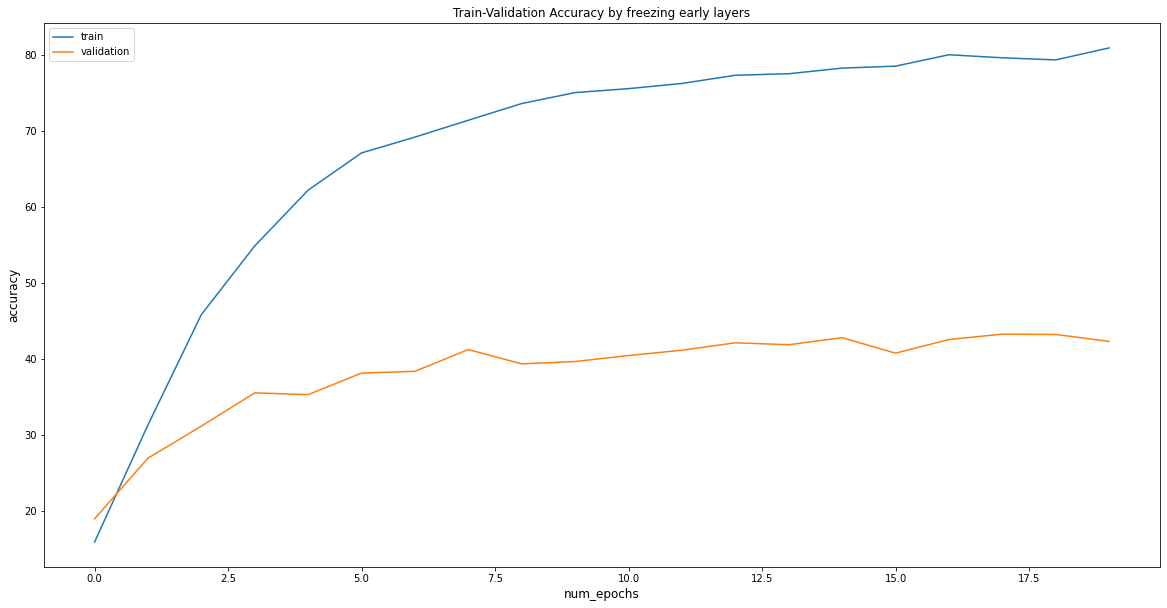

In [12]:
#View the accuracy of the model on test and train data
title_sub = "by freezing early layers" if FREEZE_EARLY_LAYERS else "without freezing early layers"
fig = plt.figure(figsize=(20,10))
plt.title(f"Train-Validation Accuracy {title_sub}")
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')
plt.savefig(f"Train-Validation Accuracy {title_sub}.jpg")


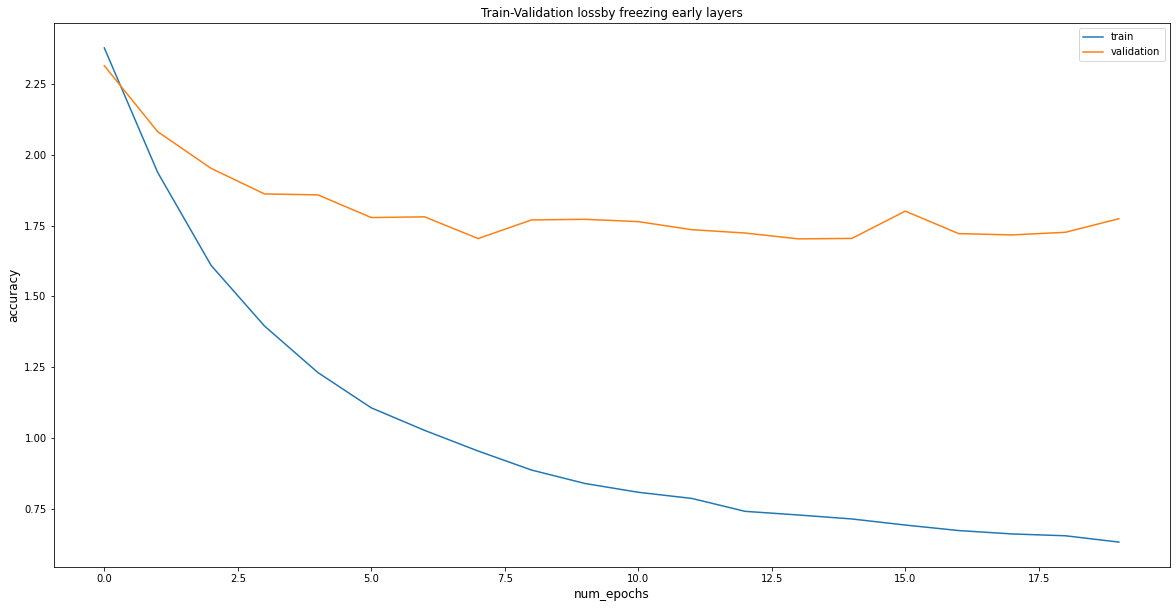

In [13]:
#View the loss of the model on test and train data
fig = plt.figure(figsize=(20,10))
plt.title(f"Train-Validation loss{title_sub}")
plt.plot(train_loss, label='train')
plt.plot(val_loss, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')
plt.savefig(f"Train-Validation loss {title_sub}.jpg")

<h1>Conclusions


I ran 20 epochs on pretrained resnet-34 models 

1->by freezing weights in  the initial layers 
2->by allwoing all the weights to train

Freezing all the weights except for the final fully connected layer gives the low accuracy in the early epochs and gradually move to overfitting probably because of the few training data.


Not freezing any weight at all allows the model to quickly optimize to local minima for training data but with overfitting.

---

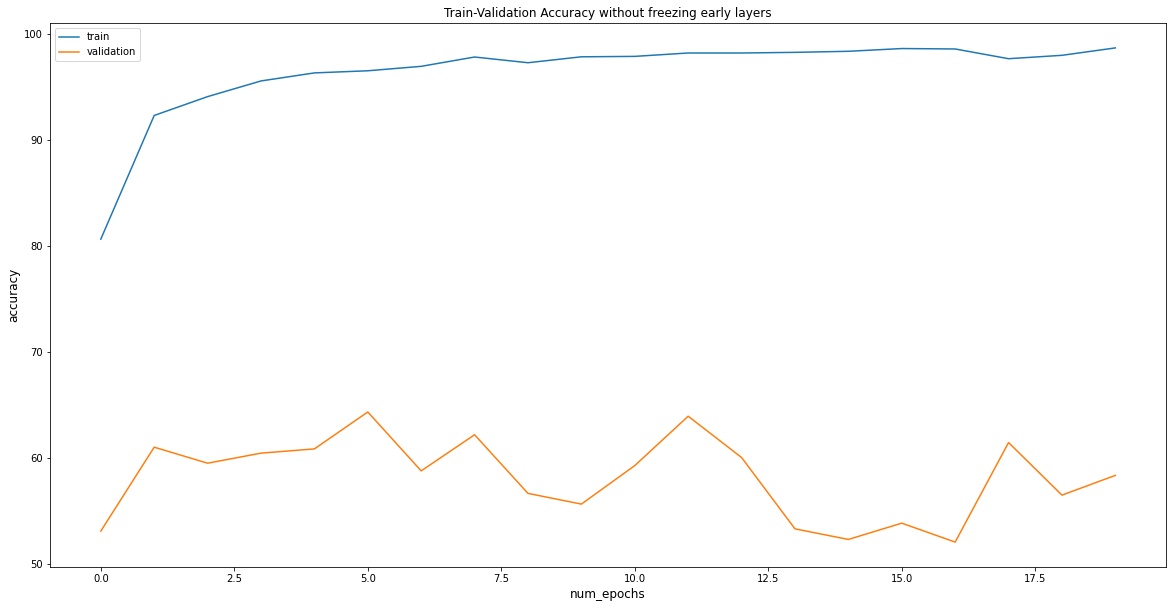



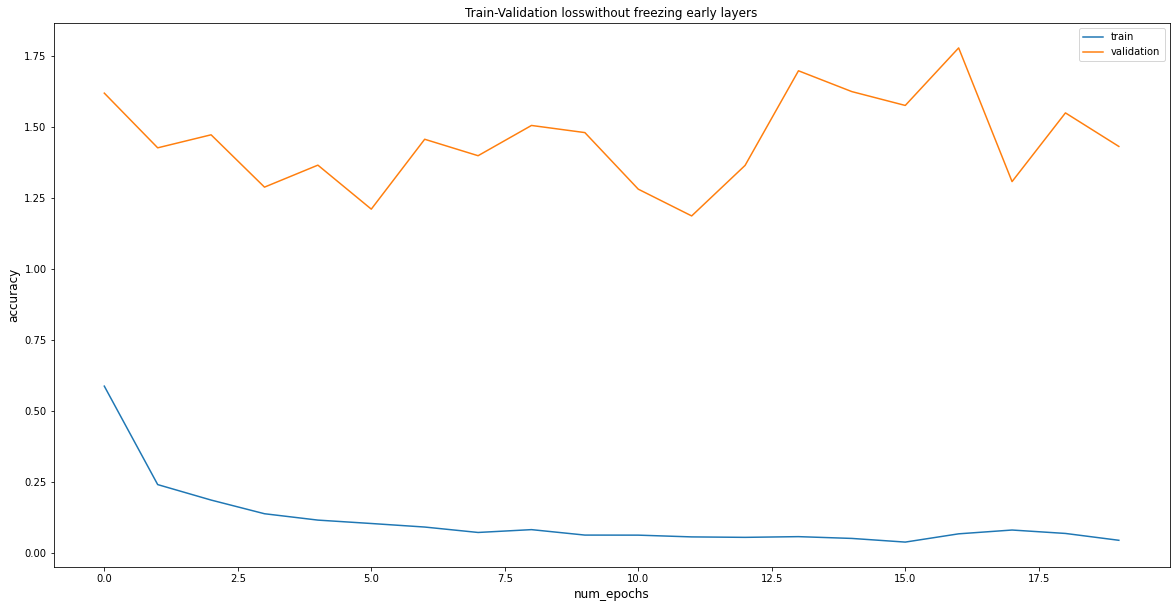

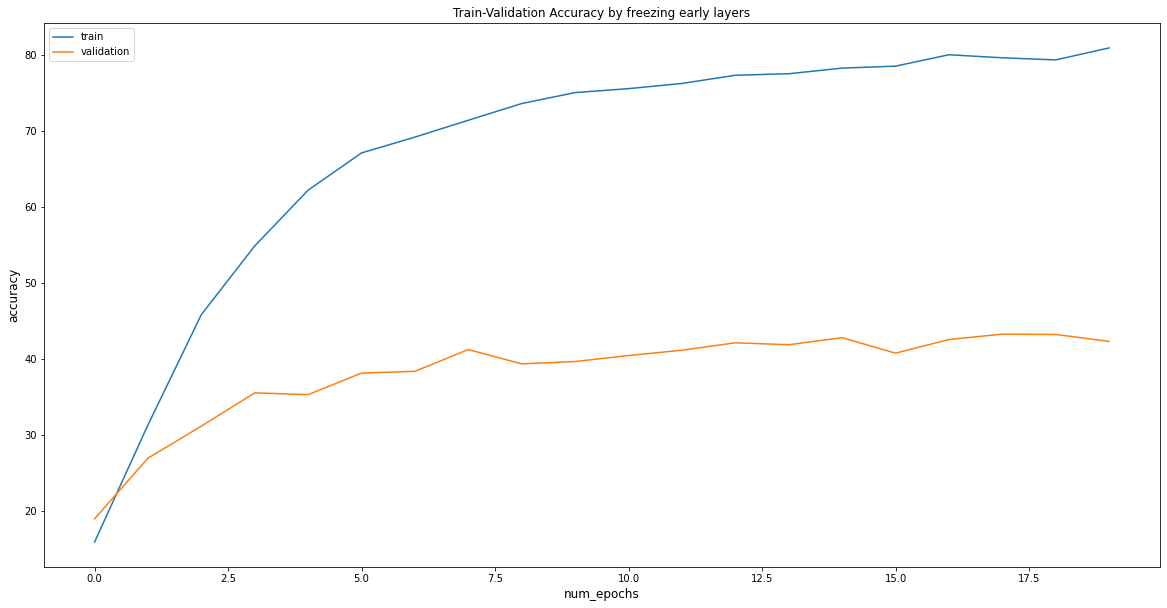

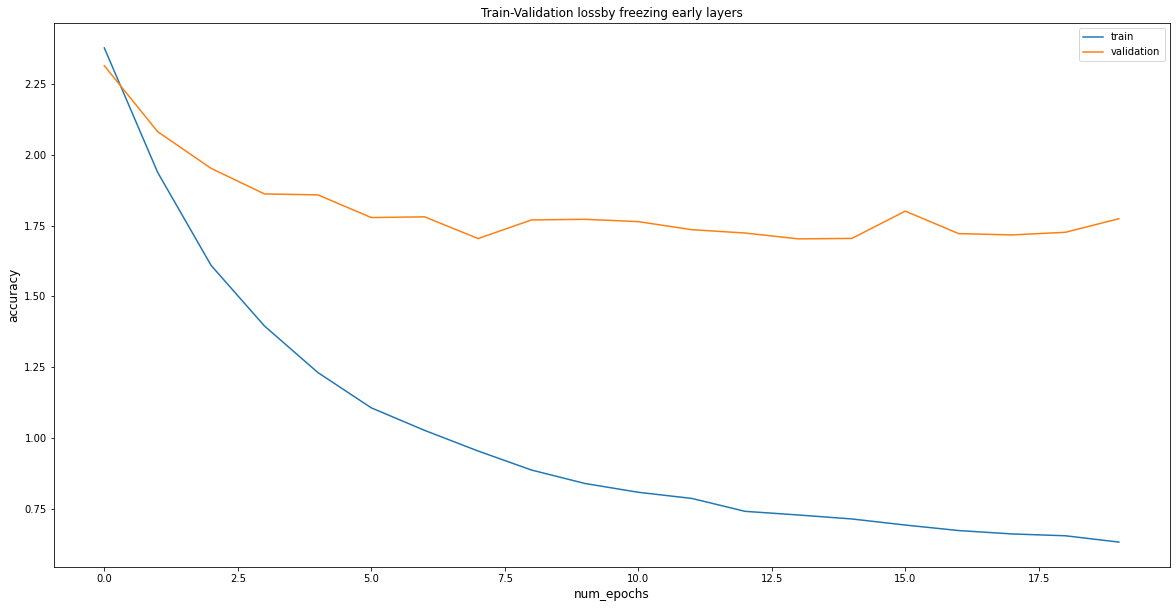



In [ ]:
# net

# for param in net.layer1.parameters():
#     param.requires_grad = True
# #Freeze only the certain named layer
# net.layer1.requires_grad = False
# params = net.state_dict()
# params.keys()
# help(net)

# ignored_params = list(map(id, net.fc.parameters()))
# base_params = filter(lambda p: id(p) not in ignored_params,
#                      net.parameters())
# for para in base_params:
#   para.requires_grad = False
# lr=0.001
# optimizer = torch.optim.SGD([
#             # {'params': base_params},
#             {'params': net.fc.parameters(), 'lr': lr}
#         ], lr=lr*0.1, momentum=0.9)
# optimizer = optim.SGD(filter(lambda p: p.requires_grad, net.parameters()), lr=0.0001, momentum=0.9)